**Цей проект має на меті:**

1) порівняти роботу бібліотек scipy.stats та pingouin - це бібліотеки для статистичних тестів

2) виконати тест анова та непарметричний анова (Kruskal-Wallis) і порівняти їх результати

3) Створити діаграму, яка досліджує зв'язок між різними категоріальними змінними (холестерин, глюкоза, куріння, вживання алкоголю, активність та наявність зайвої ваги) та серцево-судинними захворюваннями

4) і візуалізувати карту кореляцій

In [1]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg


In [ ]:
# Import data
df = pd.read_csv('medical_examination.csv')

Базова статистика

In [ ]:
print(df.head())
df.info()
print(df.describe())

   id    age  sex  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393    2     168    62.0    110     80            0     0      0   
1   1  20228    1     156    85.0    140     90            1     0      0   
2   2  18857    1     165    64.0    130     70            1     0      0   
3   3  17623    2     169    82.0    150    100            0     0      0   
4   4  17474    1     156    56.0    100     60            0     0      0   

   alco  active  cardio  overweight  
0     0       1       0           0  
1     0       1       1           1  
2     0       0       1           0  
3     0       1       1           1  
4     0       0       0           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   sex          70000 non-null

Бачимо що вік у нас в днях, тому перводимо у роки

In [ ]:
df['age_years'] = df['age'] / 365
df['age_years'].head()

0    50.391781
1    55.419178
2    51.663014
3    48.282192
4    47.873973
Name: age_years, dtype: float64

Далі, тести на нормальність працюють добре до 5000 спостережень у мене їх 70000,
тому я видалю 65001 рандомних рядків

In [ ]:

indexes_to_drop = np.random.choice(df.index, 65001, replace=False)
df_dropped = df.drop(indexes_to_drop)
print(df_dropped.head())

    id    age  sex  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
2    2  18857    1     165    64.0    130     70            3     1      0   
12  18  14791    2     165    60.0    120     80            1     1      0   
39  53  18126    1     165    70.0    140     90            1     1      0   
40  54  19848    1     157    62.0    110     70            1     1      0   
46  61  18207    1     162   107.0    150     90            2     1      0   

    alco  active  cardio  age_years  
2      0       0       1  51.663014  
12     0       0       0  40.523288  
39     0       1       1  49.660274  
40     0       0       0  54.378082  
46     0       1       1  49.882192  


In [ ]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 2 to 69998
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4999 non-null   int64  
 1   age          4999 non-null   int64  
 2   sex          4999 non-null   int64  
 3   height       4999 non-null   int64  
 4   weight       4999 non-null   float64
 5   ap_hi        4999 non-null   int64  
 6   ap_lo        4999 non-null   int64  
 7   cholesterol  4999 non-null   int64  
 8   gluc         4999 non-null   int64  
 9   smoke        4999 non-null   int64  
 10  alco         4999 non-null   int64  
 11  active       4999 non-null   int64  
 12  cardio       4999 non-null   int64  
 13  age_years    4999 non-null   float64
dtypes: float64(2), int64(12)
memory usage: 585.8 KB


In [ ]:
w_statistic, p_value = stats.shapiro(df_dropped['age_years'])
print(p_value)

2.0317958472430542e-32


In [ ]:
pg.normality(df_dropped['age_years'])

,W,pval,normal
age_years,0.966907,2.031796e-32,False


за двома бібліотеками, бачимо одне і теж значення розподілу

отже, розподіл не нормальний  оскільки 0 < 0.05

Потрібно використати не параметричний Анова, але я хочу порівняти результати між непараметричним і параметричним

ділим дані по категоріям (як категоріальну зміну я беру рівень холестеролу 1: normal, 2: above normal, 3: well above normal та рівень глюкози 1: normal, 2: above normal, 3: well above normal, як кількісну - вік)

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# Функція для розрахунку статистики
def calculate_statistics(group):
    count = group.shape[0]
    mean = group['age_years'].mean()
    std = group['age_years'].std()
    return count, mean, std

# Розділення на групи за категорією "холестерол"
ch1 = df_dropped[df_dropped["cholesterol"] == 1]
ch2 = df_dropped[df_dropped["cholesterol"] == 2]
ch3 = df_dropped[df_dropped["cholesterol"] == 3]

# Розділення на групи за категорією "глюкоза"
g1 = df_dropped[df_dropped["gluc"] == 1]
g2 = df_dropped[df_dropped["gluc"] == 2]
g3 = df_dropped[df_dropped["gluc"] == 3]

# Аналіз за категоріальними змінними

print("Аналіз за категорією 'Cholesterol':")
print("1: normal")
count_ch1, mean_ch1, std_ch1 = calculate_statistics(ch1)
print("   Кількість спостережень:", count_ch1)
print("   Середнє значення віку:", mean_ch1)
print("   Стандартне відхилення віку:", std_ch1)

print("2: above normal")
count_ch2, mean_ch2, std_ch2 = calculate_statistics(ch2)
print("   Кількість спостережень:", count_ch2)
print("   Середнє значення віку:", mean_ch2)
print("   Стандартне відхилення віку:", std_ch2)

print("3: well above normal")
count_ch3, mean_ch3, std_ch3 = calculate_statistics(ch3)
print("   Кількість спостережень:", count_ch3)
print("   Середнє значення віку:", mean_ch3)
print("   Стандартне відхилення віку:", std_ch3)

print("\nАналіз за категорією 'Glucose':")
print("1: normal")
count_g1, mean_g1, std_g1 = calculate_statistics(g1)
print("   Кількість спостережень:", count_g1)
print("   Середнє значення віку:", mean_g1)
print("   Стандартне відхилення віку:", std_g1)

print("2: above normal")
count_g2, mean_g2, std_g2 = calculate_statistics(g2)
print("   Кількість спостережень:", count_g2)
print("   Середнє значення віку:", mean_g2)
print("   Стандартне відхилення віку:", std_g2)

print("3: well above normal")
count_g3, mean_g3, std_g3 = calculate_statistics(g3)
print("   Кількість спостережень:", count_g3)
print("   Середнє значення віку:", mean_g3)
print("   Стандартне відхилення віку:", std_g3)





Аналіз за категорією 'Cholesterol':
1: normal
   Кількість спостережень: 3785
   Середнє значення віку: 52.620565679231284
   Стандартне відхилення віку: 6.892029481353104
2: above normal
   Кількість спостережень: 650
   Середнє значення віку: 53.165205479452055
   Стандартне відхилення віку: 6.721003858785785
3: well above normal
   Кількість спостережень: 564
   Середнє значення віку: 55.73117167006704
   Стандартне відхилення віку: 5.779988312162655

Аналіз за категорією 'Glucose':
1: normal
   Кількість спостережень: 4279
   Середнє значення віку: 52.79482147602019
   Стандартне відхилення віку: 6.866483322277463
2: above normal
   Кількість спостережень: 353
   Середнє значення віку: 53.62432379991463
   Стандартне відхилення віку: 6.608976471271916
3: well above normal
   Кількість спостережень: 367
   Середнє значення віку: 55.36833264902392
   Стандартне відхилення віку: 6.001506804507569


Середнє значення в групах різне

візуалізуємо групи

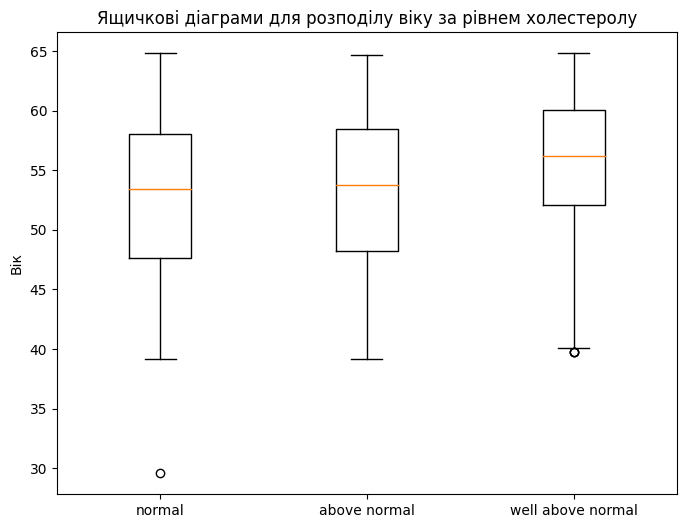

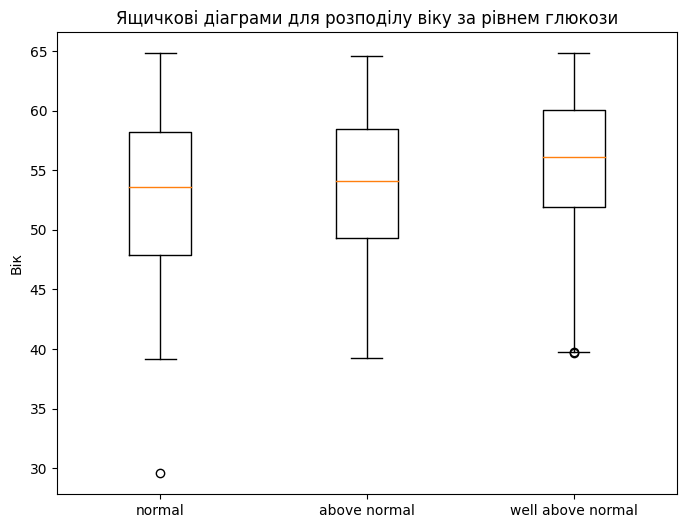

In [ ]:
# Розділення на групи за категорією "холестерол"
ch1 = df_dropped[df_dropped["cholesterol"] == 1]
ch2 = df_dropped[df_dropped["cholesterol"] == 2]
ch3 = df_dropped[df_dropped["cholesterol"] == 3]

# Розділення на групи за категорією "глюкоза"
g1 = df_dropped[df_dropped["gluc"] == 1]
g2 = df_dropped[df_dropped["gluc"] == 2]
g3 = df_dropped[df_dropped["gluc"] == 3]

# Створення списків для ящичкових діаграм
groups_ch = [ch1['age_years'], ch2['age_years'], ch3['age_years']]
groups_g = [g1['age_years'], g2['age_years'], g3['age_years']]

# Побудова ящичкових діаграм

# Для статі (Sex)
plt.figure(figsize=(8, 6))
plt.boxplot(groups_ch, labels=['normal', 'above normal', 'well above normal'])
plt.title("Ящичкові діаграми для розподілу віку за рівнем холестеролу")
plt.ylabel("Вік")
plt.show()

# Для діагнозу електрокардіограми у спокої (RestingECG)
plt.figure(figsize=(8, 6))
plt.boxplot(groups_g, labels=['normal', 'above normal', 'well above normal'])
plt.title("Ящичкові діаграми для розподілу віку за рівнем глюкози")
plt.ylabel("Вік")
plt.show()

Тут ми бачимо те саме, що середнє значення різне

Тепер робимо аналіз

У нас такі гіпотези:


H0 - нульова гіпотезу про те, що всі групи мають однакові
середні значення.

H1 -  є статистично значущі відмінності між
середніми значеннями

In [ ]:

from scipy.stats import f_oneway

# Проведення однофакторного дисперсійного аналізу
f_value, p_value = f_oneway(ch1['age_years'], ch2['age_years'], ch3['age_years'])

# Виведення результатів
print("F-значення:", f_value)
print("p-значення:", p_value)

F-значення: 52.19025376383639
p-значення: 3.6948030065295843e-23


тут ми відхиляємо 0

In [ ]:
from scipy.stats import kruskal


h_value, p_value = kruskal(ch1['age_years'], ch2['age_years'], ch3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 99.28748254241306
p-значение: 2.7542103430087673e-22


За непараметричним тестом Анова (Kruskal-Wallis), теж відхиляємо 0 гіпотезу

In [ ]:

anova = pg.anova(data=df, dv='age_years', between=['cholesterol', 'gluc'], detailed=True)

# Виведення результатів
print(anova)

               Source            SS       DF            MS           F  \
0         cholesterol  5.171142e+04      2.0  25855.708437  581.675798   
1                gluc  2.639305e+03      2.0   1319.652465   29.688218   
2  cholesterol * gluc  3.769901e+03      4.0    942.475186   21.202862   
3            Residual  3.111126e+06  69991.0     44.450377         NaN   

           p-unc       np2  
0  2.869962e-251  0.016350  
1   1.294306e-13  0.000848  
2   1.704554e-17  0.001210  
3            NaN       NaN  


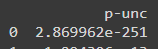

тут ми теж відхиляємо 0 гіпотезу

In [ ]:
from scipy.stats import kruskal


h_value, p_value = kruskal(g1['age_years'], g2['age_years'], g3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 48.89235005880263
p-значение: 2.416356902079831e-11


 інша група, результат тей же відхиляємо 0 гіпотезу

візуально, середнє значення 2х груп рівні, я зроблю т-тест

Н0 середнє значення 2 груп рівне

н1 середнє значення 2 груп різне

In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(ch1['age_years'], ch2['age_years'])

print("t-статистика:", t_statistic)
print("p-значение:", p_value)


t-статистика: -1.8679655979789584
p-значение: 0.06183279250409164


справдилась н1

тепер зробимо на більшу вибірку, без видалення великої кількості рядків

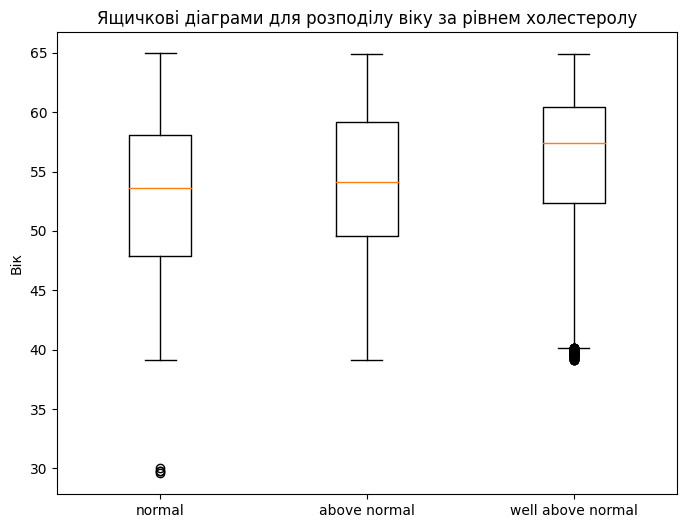

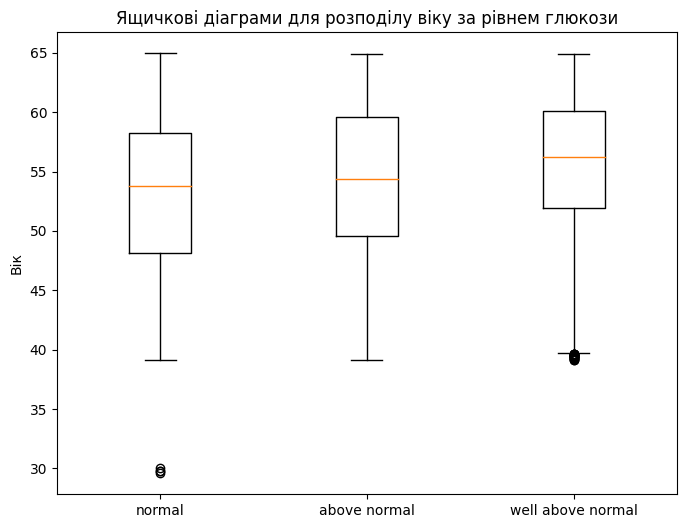

In [ ]:
# Розділення на групи за категорією "холестерол"
ch1 = df[df["cholesterol"] == 1]
ch2 = df[df["cholesterol"] == 2]
ch3 = df[df["cholesterol"] == 3]

# Розділення на групи за категорією "глюкоза"
g1 = df[df["gluc"] == 1]
g2 = df[df["gluc"] == 2]
g3 = df[df["gluc"] == 3]

# Створення списків для ящичкових діаграм
groups_ch = [ch1['age_years'], ch2['age_years'], ch3['age_years']]
groups_g = [g1['age_years'], g2['age_years'], g3['age_years']]

# Побудова ящичкових діаграм

plt.figure(figsize=(8, 6))
plt.boxplot(groups_ch, labels=['normal', 'above normal', 'well above normal'])
plt.title("Ящичкові діаграми для розподілу віку за рівнем холестеролу")
plt.ylabel("Вік")
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(groups_g, labels=['normal', 'above normal', 'well above normal'])
plt.title("Ящичкові діаграми для розподілу віку за рівнем глюкози")
plt.ylabel("Вік")
plt.show()

In [ ]:

anova = pg.anova(data=df, dv='age_years', between=['cholesterol', 'gluc'], detailed=True)
print(anova)

               Source            SS       DF            MS           F  \
0         cholesterol  5.171142e+04      2.0  25855.708437  581.675798   
1                gluc  2.639305e+03      2.0   1319.652465   29.688218   
2  cholesterol * gluc  3.769901e+03      4.0    942.475186   21.202862   
3            Residual  3.111126e+06  69991.0     44.450377         NaN   

           p-unc       np2  
0  2.869962e-251  0.016350  
1   1.294306e-13  0.000848  
2   1.704554e-17  0.001210  
3            NaN       NaN  


Тут теж відхиляємо нульову гіпотезу і зробимо не параметричний

In [ ]:
from scipy.stats import kruskal
h_value, p_value = kruskal(g1['age_years'], g2['age_years'], g3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 699.4875584456599
p-значение: 1.2829407609358133e-152


підтвержується н1

в результаті дисперсійного аналізу було знайдено статистично
значущі відмінності, можна провести пост-гок аналіз, щоб з'ясувати, між якими
саме групами існують ці відмінності.

Якщо інтервал довіри для різниці середніх не охоплює нуль, і
p-значення менше 0.05, між групами існує статистично значуща різниця.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Підготовка даних для Тьюків тесту
data = np.concatenate([ch1['age_years'], ch2['age_years'], ch3['age_years']])
groups = ['1'] * len(ch1) + ['2'] * len(ch2) + ['3'] * len(ch3)
df = pd.DataFrame({'Age': data, 'Cholesterol': groups})

# Проведення Тьюків тесту
tukey_results = pairwise_tukeyhsd(endog=df['Age'], groups=df['Cholesterol'], alpha=0.05)

print(tukey_results)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2    0.881   0.0  0.707 1.0551   True
     1      3   3.3689   0.0 3.1818  3.556   True
     2      3   2.4879   0.0 2.2514 2.7245   True
-------------------------------------------------


Як бачимо всі результати True, тоб-то існує статистично значуща різниця

Робимо візуалізацію, для початку потрібно всі дані зробити з однаковими значеннями, тобто бінарними і знаходимо  BMI, якщо людина має індекс більше ніж 25б то в неї зайва вага

Бачимо, що для наявності сецево-судинних захворювань, характерна зайва вага, підвищений рівень глюкози та холестеролу. І меньша активність

In [ ]:
df = pd.read_csv('medical_examination.csv')

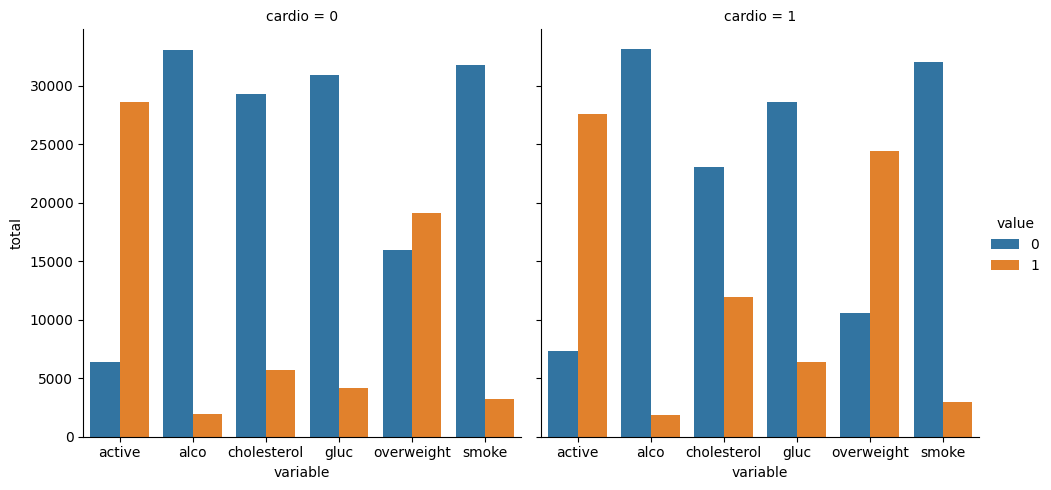

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['overweight'] = ((df['weight'] / (df['height'] / 100) ** 2) > 25).astype(int)
df['cholesterol'] = (df['cholesterol'] > 1).astype(int)
df['gluc'] = (df['gluc'] > 1).astype(int)

df_cat = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'overweight'])

df_cat = df_cat.groupby(['cardio', 'variable', 'value']).size().reset_index(name='total')

graph = sns.catplot(data=df_cat, kind="bar", x="variable", y="total", hue="value", col="cardio")
plt.show()


In [ ]:
df_heat = df[(df['ap_lo'] <= df['ap_hi']) &
             (df['height'] >= df['height'].quantile(0.025)) &
             (df['height'] <= df['height'].quantile(0.975)) &
             (df['weight'] >= df['weight'].quantile(0.025)) &
             (df['weight'] <= df['weight'].quantile(0.975))
             ]

# Calculate the correlation matrix
corr = df_heat.corr()

print(corr)



                   id       age       sex    height    weight     ap_hi  \
id           1.000000  0.002507  0.003426  0.000326  0.000149  0.003492   
age          0.002507  1.000000 -0.018132 -0.076932  0.070168  0.018689   
sex          0.003426 -0.018132  1.000000  0.505785  0.129979  0.005063   
height       0.000326 -0.076932  0.505785  1.000000  0.251503  0.004586   
weight       0.000149  0.070168  0.129979  0.251503  1.000000  0.027030   
ap_hi        0.003492  0.018689  0.005063  0.004586  0.027030  1.000000   
ap_lo        0.000484  0.153508  0.059947  0.017922  0.227922  0.072803   
cholesterol  0.003719  0.129996 -0.037605 -0.063522  0.135981  0.022807   
gluc         0.002289  0.086990 -0.021357 -0.030469  0.107072  0.011111   
smoke       -0.002732 -0.044371  0.337436  0.187830  0.056533 -0.001928   
alco        -0.000708 -0.026970  0.168637  0.089785  0.059917  0.000769   
active       0.005891 -0.011445  0.007864 -0.005661 -0.014430 -0.000222   
cardio       0.003900  0.

In [ ]:
import plotly.io as pio
import plotly.express as px
df_heat = df[(df['ap_lo'] <= df['ap_hi']) &
             (df['height'] >= df['height'].quantile(0.025)) &
             (df['height'] <= df['height'].quantile(0.975)) &
             (df['weight'] >= df['weight'].quantile(0.025)) &
             (df['weight'] <= df['weight'].quantile(0.975))
             ]

fig6 = px.imshow(df_heat.corr(),
                 color_continuous_scale='sunset',
                 )
fig6.show()

Статистичний зв*язок між данними

Сильна кореляція:



Вік  має помірну позитивну кореляцію з наявністю серцево-судинних захворювань (0.24). Це  очікувано, оскільки з віком збільшується ризик розвитку серцево-судинних захворювань.
Позитивна кореляція між зростом  і статевою приналежністю  також відображає біологічний зв'язок між цими двома факторами (0.51).
Вага має помірну позитивну кореляцію з наявністю серцево-судинних захворювань (0.17).

Рівень глюкози і куріння показують слабку кореляцію з наявністю серцево-судинних захворювань.
Алкоголь  і рівень фізичної активності також мають слабку кореляцію з наявністю серцево-судинних захворювань .

Отже, зроблю висновок:

1) різниці між сатитичними бібліотеками я не побачила, мені сподобалося працювати з pingouin

1) я виконала тест анова та Kruskal-Wallis, вони обидва відхилили нульову гіпотезу, хоча розподіл був не нормальний

3) діаграма була створена і було помічено, що для наявності сецево-судинних захворювань, характерна зайва вага, підвищений рівень глюкози та холестеролу. І меньша активність

4) візуалізована карта кореляцій, висновки з карти вище